<a href="https://colab.research.google.com/github/lbovet8/phys152-2026/blob/main/Projects/HiggsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
#from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

import xgboost
from xgboost import XGBClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Load data
data = pd.read_csv('/content/drive/My Drive/ML_Project/HIGGS.csv.gz')
# only work with a small fraction
data = data.sample(frac=0.001, random_state=42)

In [25]:
# first column is label, all columns after are features
y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# define inout data only with low level features
X_train_low = X_train[:, :21]
X_test_low = X_test[:, :21]

In [26]:
print(f"Total Dataset: {len(data)}")

print(f"Training all features shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing all features shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

print(f"Training low features shape: {X_train_low.shape}")
print(f"Testing low features shape: {X_test_low.shape}")

Total Dataset: 11000
Training all features shape: (8800, 28), Training labels shape: (8800,)
Testing all features shape: (2200, 28), Testing labels shape: (2200,)
Training low features shape: (8800, 21)
Testing low features shape: (2200, 21)


# Visualization of features for both labels

In [27]:
# Take a look at data
print(y_train[0])
print(y_train[1])
print(len(X_train[0]))
print(X_train[0])
print(X_train[0][0])

0.0
1.0
28
[ 0.46539214  0.55997789  1.27215874  1.01993394 -1.14867222  0.56310958
  0.55054241 -0.23111621  0.          1.16876221  0.56442833 -1.23581195
  1.10743606  0.83701128  0.6819492   0.64617217  1.27411222  2.17508626
 -0.41520667  0.69625318  0.          1.56306314  1.0016346   0.98212677
  0.73847508  1.04655933  0.97272199  0.85663688]
0.465392142534256


In [28]:
def plot_one_feature(training_input_data, training_output_data, feature_int):

  # try like this instead as improvement
  mask_0 = training_output_data == 0.0 # makes a boolean list
  mask_1 = training_output_data == 1.0

  x_data_label_0 = training_input_data[mask_0, feature_int] #select data with mask requirement and with array[row, column]
  x_data_label_1 = training_input_data[mask_1, feature_int]

  # Plot
  plt.figure(figsize=(6, 4))
  plt.hist(x_data_label_0, bins=50, alpha=0.5, color='pink', label='Background')
  plt.hist(x_data_label_1, bins = 50, alpha=0.5, color='purple', label='Signal')
  plt.xlabel('Value of Feature')
  plt.ylabel('Number of Events')
  plt.legend()
  plt.title(f"Feature Nr. {feature_int}")
  plt.show()

In [29]:
def plot_all_features(training_input_data, training_output_data):

    fig, axes = plt.subplots(7, 4, figsize=(16, 21))
    axes = axes.flatten()

    for feature_int in range(28):

        # try like this instead as improvement
        mask_0 = training_output_data == 0.0 # makes a boolean list
        mask_1 = training_output_data == 1.0

        x_data_label_0 = training_input_data[mask_0, feature_int] #select data with mask requirement and  with array[row, column]
        x_data_label_1 = training_input_data[mask_1, feature_int]

        axes[feature_int].hist(x_data_label_0, bins=50, alpha=0.5, color='pink', label='Background')
        axes[feature_int].hist(x_data_label_1, bins=50, alpha=0.5, color='purple', label='Signal')

        axes[feature_int].set_title(f"Feature {feature_int}")
        axes[feature_int].tick_params(labelsize=8)

    plt.tight_layout()
    fig.supxlabel("Feature Value", fontsize=14)
    fig.supylabel("Number of Events", fontsize=14)
    plt.show()



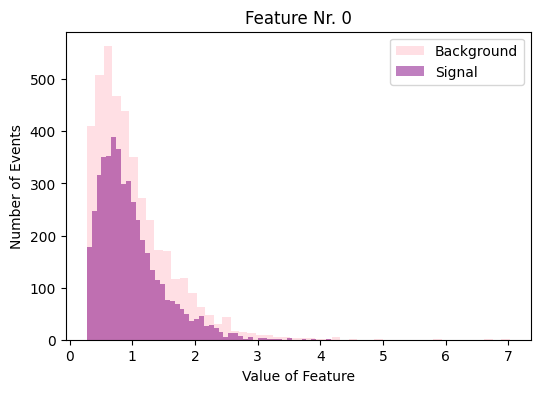

In [30]:
plot_one_feature(X_train, y_train, 0)

In [9]:
#plot_all_features(X_train, y_train)


I am surprised how many signals we have here. They are as many as the background or even larger.

# Implement Decision Tree

In [31]:
N_ESTIMATORS = 500
MAX_DEPTH = 4
LEARNING_RATE_DT = 0.05
OBJECTIVE = 'binary:logistic'

In [32]:
xgbclf_high = XGBClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE_DT, objective=OBJECTIVE)
# fit model
xgbclf_high.fit(X_train, y_train)
# make predictions
#preds = xgbclf_high.predict(X_test)
xgbclf_high.score(X_train,y_train), xgbclf_high.score(X_test,y_test)

#print(f'Parameters used for all features: {xgbclf_high.get_params()}.')

(0.8582954545454545, 0.7145454545454546)

In [33]:
xgbclf_low = XGBClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE_DT, objective=OBJECTIVE)
# fit model
xgbclf_low.fit(X_train_low, y_train)
# make predictions
#preds = xgbclf_high.predict(X_test)
xgbclf_low.score(X_train_low, y_train), xgbclf_low.score(X_test_low,y_test)

#print(f'Parameters used for low features: {xgbclf_low.get_params()}.')

(0.8307954545454546, 0.5945454545454546)

# Evaluate Decision Tree

## Confusion Matrix

In [34]:
def plot_confusion_matrix_dt(decision_tree, testing_input_data, testing_output_data, title_str ):
  # Get predictions from the DecisionTreeClassifier on the test set
  y_pred_xgbclf = decision_tree.predict(testing_input_data)

  # Create confusion matrix for Decision Tree
  cm_xgbclf = confusion_matrix(testing_output_data, y_pred_xgbclf)

  plt.figure(figsize=(6, 5))
  sns.heatmap(cm_xgbclf, annot=True, fmt='d', cmap='RdPu')
  plt.title(title_str)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

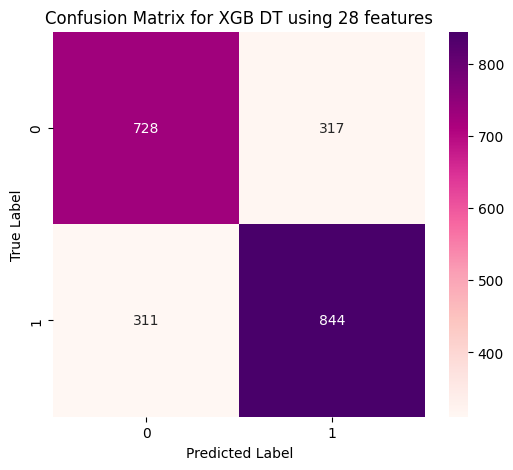

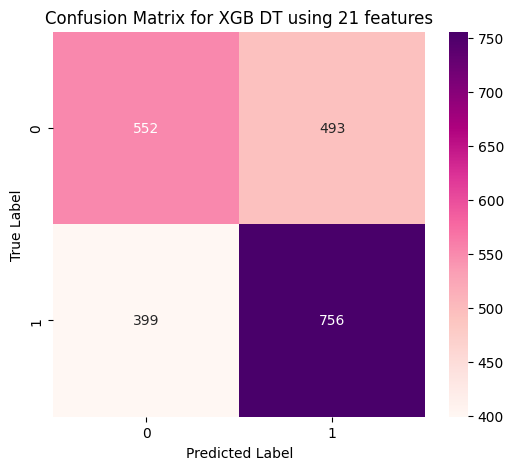

In [35]:
plot_confusion_matrix_dt(xgbclf_high, X_test, y_test, "Confusion Matrix for XGBoost Classifier using 28 features")
plot_confusion_matrix_dt(xgbclf_low, X_test_low, y_test, "Confusion Matrix for XGBoost Classifier using 21 features")

## ROC Curve

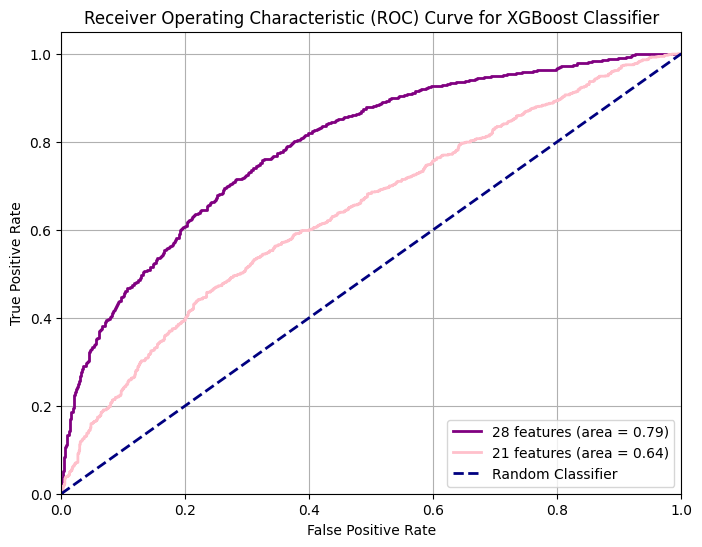

In [36]:
# Get predicted probabilities for the positive class
y_pred_proba_xgbclf_high = xgbclf_high.predict_proba(X_test)[:, 1]
y_pred_proba_xgbclf_low = xgbclf_low.predict_proba(X_test_low)[:, 1]

# Calculate ROC curve
fpr_high, tpr_high, thresholds_high = roc_curve(y_test, y_pred_proba_xgbclf_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, thresholds_low = roc_curve(y_test, y_pred_proba_xgbclf_low)
roc_auc_low = auc(fpr_low, tpr_low)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='purple', lw=2, label=f'28 features (area = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='pink', lw=2, label=f'21 features (area = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Implement DNN

In [38]:
# use Dataloader
# normalize the input features to be within (0,1)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_train_low = torch.FloatTensor(X_train_low)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
X_test_low = torch.FloatTensor(X_test_low)
y_test = torch.LongTensor(y_test)

# create TensorDataset
train_dataset_high = TensorDataset(X_train, y_train)
test_dataset_high = TensorDataset(X_test, y_test)
train_dataset_low = TensorDataset(X_train_low, y_train)
test_dataset_low = TensorDataset(X_test_low, y_test)

# create PyTorch DataLoader with batches for training
train_loader_high = DataLoader(
    train_dataset_high,
    batch_size=16,      # Adjust based on your needs
    shuffle=True        # Shuffle training data in batches
)

test_loader_high = DataLoader(
    test_dataset_high,
    batch_size=16,
    shuffle=False       # Don't shuffle test data
)

train_loader_low = DataLoader(
    train_dataset_low,
    batch_size=16,      # Adjust based on your needs
    shuffle=True        # Shuffle training data in batches
)

test_loader_low = DataLoader(
    test_dataset_low,
    batch_size=16,
    shuffle=False       # Don't shuffle test data
)

#print(f"Training samples all features: {len(train_dataset_high)}")
#print(f"Training samples low features: {len(train_dataset_low)}")
#print(f"Test samples all features: {len(test_dataset_high)}")
#print(f"Test samples low features: {len(test_dataset_low)}")
#print(f"Batches per epoch: {len(train_loader)}")

In [39]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [60]:
class HiggsDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [67]:
def train_dnn(model, train_loader, epochs=100, lr=0.01, momentum=0.9):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    history = {"train_loss": [], "train_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for data, target in train_loader:
            data   = data.to(device)
            target = target.view(-1, 1).float().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss   = criterion(output, target)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            correct      += ((output > 0.5) == target).sum().item()
            total        += data.size(0)

        history["train_loss"].append(running_loss / total)
        history["train_acc"].append(correct / total)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  "
                  f"train_loss={history['train_loss'][-1]:.4f}  "
                  f"train_acc={history['train_acc'][-1]:.3f}")

    return history

In [74]:
# Create model for low features
dnn_low = HiggsDNN(input_size=21, hidden_size=300)
dnn_low = dnn_low.to(device)
#print(dnn_low)
#print(f"\nTotal parameters: {sum(p.numel() for p in dnn_low.parameters()):,}")

In [75]:
# Create model for all features
dnn_high = HiggsDNN(input_size=28, hidden_size=300)
dnn_high = dnn_high.to(device)
#print(dnn_high)
#print(f"\nTotal parameters: {sum(p.numel() for p in dnn_high.parameters()):,}")

In [76]:
print('Training DNN with 21 features:')
history_low = train_dnn(dnn_low, train_loader_low, epochs=100, lr=0.01)
print('------------------------------------')
print('Training DNN with 28 features:')
history_high = train_dnn(dnn_high, train_loader_high, epochs=100, lr=0.01)

# Plot training
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#ax1.plot(history_low["train_loss"], label='Train Loss', marker='o')
#ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
#ax2.plot(history_low["train_acc"], label='Train Acc', marker='o')
#ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)
#plt.tight_layout(); plt.show()

Training DNN with 21 features
Epoch   1/100  train_loss=0.6916  train_acc=0.529
Epoch   5/100  train_loss=0.6826  train_acc=0.556
Epoch  10/100  train_loss=0.6751  train_acc=0.577
Epoch  15/100  train_loss=0.6642  train_acc=0.596
Epoch  20/100  train_loss=0.6513  train_acc=0.614
Epoch  25/100  train_loss=0.6429  train_acc=0.621
Epoch  30/100  train_loss=0.6270  train_acc=0.645
Epoch  35/100  train_loss=0.6103  train_acc=0.664
Epoch  40/100  train_loss=0.5895  train_acc=0.684
Epoch  45/100  train_loss=0.5641  train_acc=0.706
Epoch  50/100  train_loss=0.5389  train_acc=0.723
Epoch  55/100  train_loss=0.5008  train_acc=0.751
Epoch  60/100  train_loss=0.4683  train_acc=0.773
Epoch  65/100  train_loss=0.4209  train_acc=0.805
Epoch  70/100  train_loss=0.3724  train_acc=0.828
Epoch  75/100  train_loss=0.3268  train_acc=0.854
Epoch  80/100  train_loss=0.2724  train_acc=0.885
Epoch  85/100  train_loss=0.2181  train_acc=0.907
Epoch  90/100  train_loss=0.1974  train_acc=0.919
Epoch  95/100  train

# Evaluate DNN

Accuracy on testing data with 21 features: 0.5686
Accuracy on testing data with 28 features: 0.6273


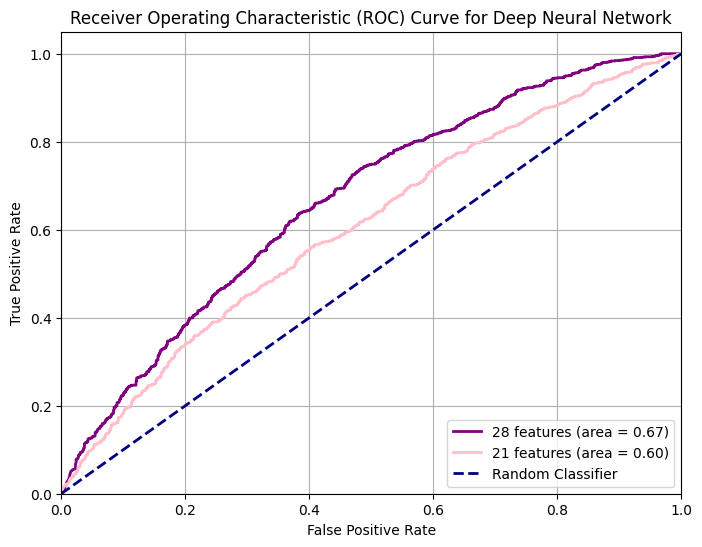

In [78]:
# Set the model to evaluation mode
dnn_low.eval()
dnn_high.eval()

all_labels_low = []
all_predictions_low = []

all_labels_high = []
all_predictions_high = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, target in test_loader_low:
        data, target = data.to(device), target.to(device)
        output = dnn_low(data)
        all_predictions_low.extend(output.cpu().numpy())
        all_labels_low.extend(target.cpu().numpy())

with torch.no_grad():
    for data, target in test_loader_high:
        data, target = data.to(device), target.to(device)
        output = dnn_high(data)
        all_predictions_high.extend(output.cpu().numpy())
        all_labels_high.extend(target.cpu().numpy())

# Convert lists to numpy arrays
y_true_low = np.array(all_labels_low)
y_pred_proba_low = np.array(all_predictions_low)

y_true_high = np.array(all_labels_high)
y_pred_proba_high = np.array(all_predictions_high)

# For binary classification with Sigmoid, output is already probability, but ensure shape is correct
# y_pred_proba will be (N, 1), we need (N,) for roc_curve
y_pred_proba_low = y_pred_proba_low.flatten()
y_true_low = y_true_low.flatten()

y_pred_proba_high = y_pred_proba_high.flatten()
y_true_high = y_true_high.flatten()

# Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
y_pred_binary_low = (y_pred_proba_low > 0.5).astype(int)
y_pred_binary_high = (y_pred_proba_high > 0.5).astype(int)


# Calculate Accuracy
accuracy_low = accuracy_score(y_true_low, y_pred_binary_low)
print(f"Accuracy on testing data with 21 features: {accuracy_low:.4f}")

accuracy_high = accuracy_score(y_true_high, y_pred_binary_high)
print(f"Accuracy on testing data with 28 features: {accuracy_high:.4f}")

# Calculate ROC curve
fpr_low, tpr_low, thresholds_low = roc_curve(y_true_low, y_pred_proba_low)
roc_auc_low = auc(fpr_low, tpr_low)

fpr_high, tpr_high, thresholds_high = roc_curve(y_true_high, y_pred_proba_high)
roc_auc_high = auc(fpr_high, tpr_high)

#print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='purple', lw=2, label=f'28 features (area = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='pink', lw=2, label=f'21 features (area = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()